<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The MoonLander Problem
</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The MoonLander Problem:* The MoonLander problem is a classic optimal control problem where we aim to land a spacecraft on the moon while minimizing the time of flight.
The problem is inspired from the following paper: [FATROP : A Fast Constrained Optimal Control Problem Solver for Robot Trajectory Optimization and Control](https://arxiv.org/pdf/2303.16746) made for [Casadi](https://web.casadi.org/) software and [Fatrop](https://github.com/meco-group/fatrop) solver.                            
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)
4. [Remarks](#rem)

</div>

In [51]:
import Pkg
Pkg.activate("..")
include("./utils.jl");
using MKL

  Activating project at `c:\Users\hajje\Dropbox\PC\Desktop\Stage\COTS`


## 1. Solving with JuMP <a id='jump'></a>

In [52]:
using JuMP , Ipopt
import HSL_jll
include("../Problems/JuMP/moonlander_JMP.jl");
nh=100;
MoonLander = moonlander_JMP(;nh=nh)

set_optimizer(MoonLander,Ipopt.Optimizer)
set_attribute(MoonLander, "print_level", 5)
set_optimizer_attribute(MoonLander,"tol",1e-8)
set_optimizer_attribute(MoonLander,"constr_viol_tol",1e-6)
set_optimizer_attribute(MoonLander,"max_iter",1000)
set_optimizer_attribute(MoonLander,"mu_strategy","adaptive")
set_attribute(MoonLander, "hsllib", HSL_jll.libhsl_path)
set_attribute(MoonLander, "linear_solver", "ma57")
set_optimizer_attribute(MoonLander, "print_timing_statistics", "yes")

In [53]:
println("Solving...")
optimize!(MoonLander)
println()

Solving...
This is Ipopt version 3.14.16, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     5010
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    10000

Total number of variables............................:      809
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      610
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.9999900e-01 5.00e+00 5.27e-02   0.0 0.00e+00    -  0.00e+00 0.00e

In [54]:
# Display results
if termination_status(MoonLander) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(MoonLander) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(MoonLander) == MOI.TIME_LIMIT && has_values(MoonLander)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(MoonLander))
println()


  (Local) solution found
  objective value = 1.0666331251370218



In [55]:
step = MoonLander[:step]

p1 = MoonLander[:p1];
p2 = MoonLander[:p2];
dp1 = MoonLander[:dp1];
dp2 = MoonLander[:dp2];
theta = MoonLander[:theta];
dtheta = MoonLander[:dtheta];

F1 = MoonLander[:F1];
F2 = MoonLander[:F2];

d_p1 = MoonLander[:d_p1];
d_p2 = MoonLander[:d_p2];
d_dp1 = MoonLander[:d_dp1];
d_dp2 = MoonLander[:d_dp2];
d_theta = MoonLander[:d_theta];
d_dtheta = MoonLander[:d_dtheta];


Δt = value(step);
t = Vector((0:nh)*Δt); 

p = - [[ dual(d_p1[i]), dual(d_p2[i]), dual(d_dp1[i]), dual(d_dp2[i]), dual(d_theta[i]), dual(d_dtheta[i]) ] for i in 1:nh];
p = costateInterpolation(p, t);

p1 = Vector(value.(p1)) ;
p2 = Vector(value.(p2)) ;
dp1 = Vector(value.(dp1)) ;
dp2 = Vector(value.(dp2)) ;
theta = Vector(value.(theta)) ;
dtheta = Vector(value.(dtheta)) ;
F1 = Vector(value.(F1)) ;
F2 = Vector(value.(F2)) ;
u = [[F1[i], F2[i]] for i in 1:nh+1];

x =  [ [ p1[i], p2[i], dp1[i], dp2[i], theta[i], dtheta[i] ] for i in 1:nh+1];

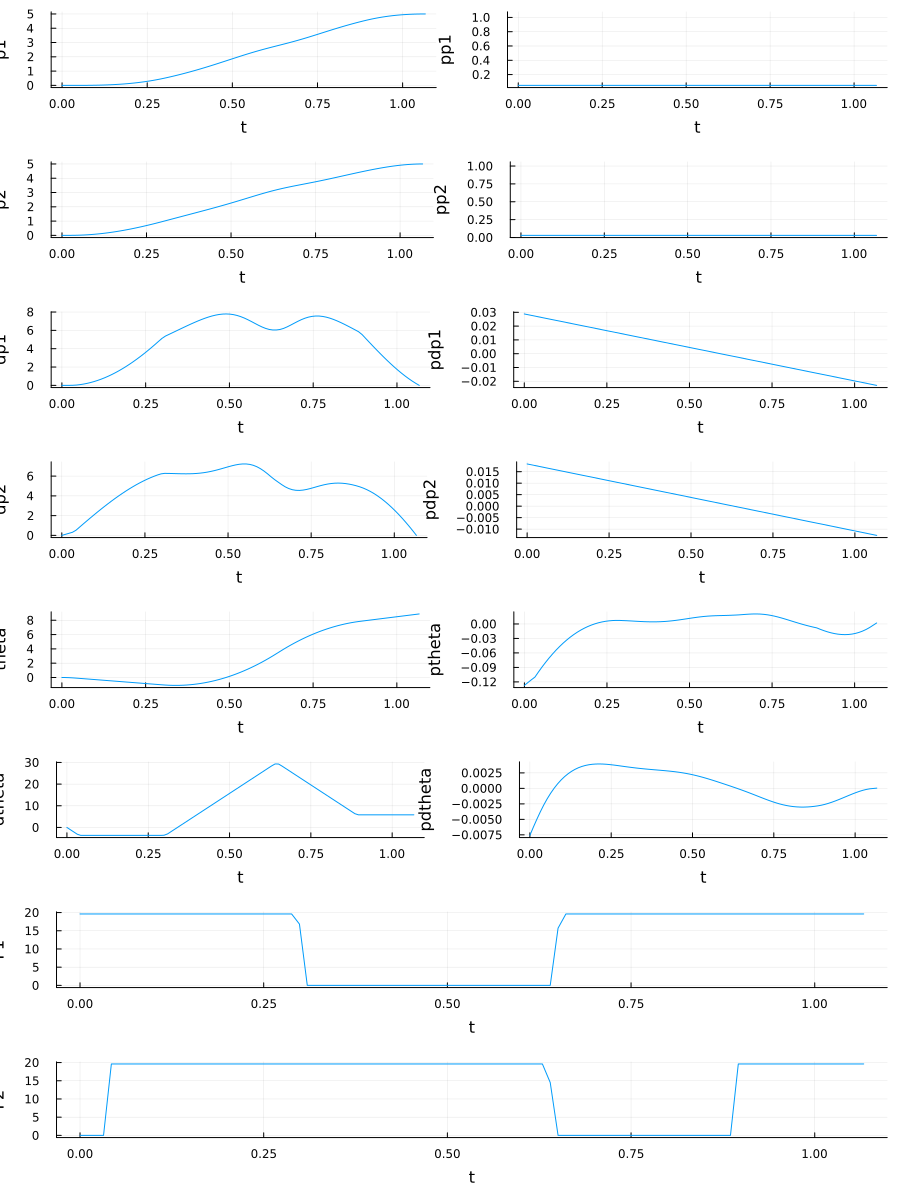

In [56]:
# For plotting results
using Plots

p1_plot = plot(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "p1", legend = false)
p2_plot = plot(t, [ x[i][2] for i in 1:nh+1], xlabel = "t", ylabel = "p2", legend = false)
dp1_plot = plot(t, [ x[i][3] for i in 1:nh+1], xlabel = "t", ylabel = "dp1", legend = false)
dp2_plot = plot(t, [ x[i][4] for i in 1:nh+1], xlabel = "t", ylabel = "dp2", legend = false)
theta_plot = plot(t, [ x[i][5] for i in 1:nh+1], xlabel = "t", ylabel = "theta", legend = false)
dtheta_plot = plot(t, [ x[i][6] for i in 1:nh+1], xlabel = "t", ylabel = "dtheta", legend = false)
pp1_plot = plot(t, [ p[i][1] for i in 1:nh+1], xlabel = "t", ylabel = "pp1", legend = false)
pp2_plot = plot(t, [ p[i][2] for i in 1:nh+1], xlabel = "t", ylabel = "pp2", legend = false)
pdp1_plot = plot(t, [ p[i][3] for i in 1:nh+1], xlabel = "t", ylabel = "pdp1", legend = false)
pdp2_plot = plot(t, [ p[i][4] for i in 1:nh+1], xlabel = "t", ylabel = "pdp2", legend = false)
ptheta_plot = plot(t, [ p[i][5] for i in 1:nh+1], xlabel = "t", ylabel = "ptheta", legend = false)
pdtheta_plot = plot(t, [ p[i][6] for i in 1:nh+1], xlabel = "t", ylabel = "pdtheta", legend = false)

F1_plot = plot(t, [ u[i][1] for i in 1:nh+1], xlabel = "t", ylabel = "F1", legend = false)
F2_plot = plot(t, [ u[i][2] for i in 1:nh+1], xlabel = "t", ylabel = "F2", legend = false)

layout = @layout [a b; c d; e f; g h ;j h; k l;o;p]
x_plot = plot(p1_plot, pp1_plot, p2_plot, pp2_plot, dp1_plot, pdp1_plot, dp2_plot, pdp2_plot, theta_plot, ptheta_plot, dtheta_plot, pdtheta_plot, F1_plot, F2_plot, layout = layout)
x_plot = plot!(x_plot, size = (900, 1200))
display(x_plot)

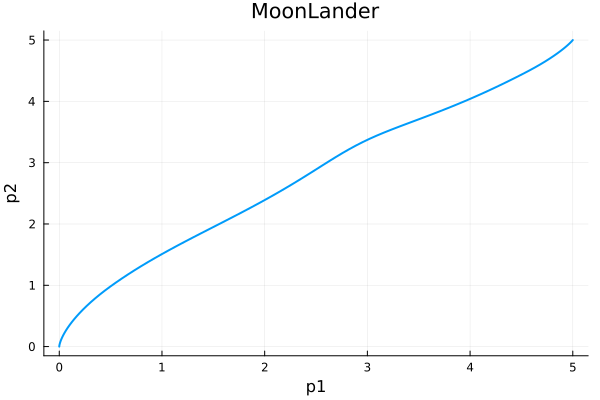

In [57]:
plot(
    p1,
    p2,
    linewidth = 2,
    legend = nothing,
    title = "MoonLander",
    xlabel = "p1",
    ylabel = "p2",
)

## 2. Solving with OptimalControl <a id='oc'></a>

In [58]:
using OptimalControl
using NLPModelsIpopt
include("../Problems/OptimalControl/moonlander_OC.jl")
MoonLanderOC = moonlander_OC();

In [59]:
# Solve the problem
import HSL_jll
init = moonlander_init(;nh=101)
sol = OptimalControl.solve(MoonLanderOC, grid_size=101, init=init,
            linear_solver="ma57",hsllib=HSL_jll.libhsl_path, print_timing_statistics="yes")

This is Ipopt version 3.14.16, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     4454
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1122

Total number of variables............................:      817
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      204
                     variables with only upper bounds:        0
Total number of equality constraints.................:      616
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e-01 4.90e+00 1.37e-05   0.0 0.00e+00    -  0.00e+00 0.00e+00   0
   

OptimalControlSolution

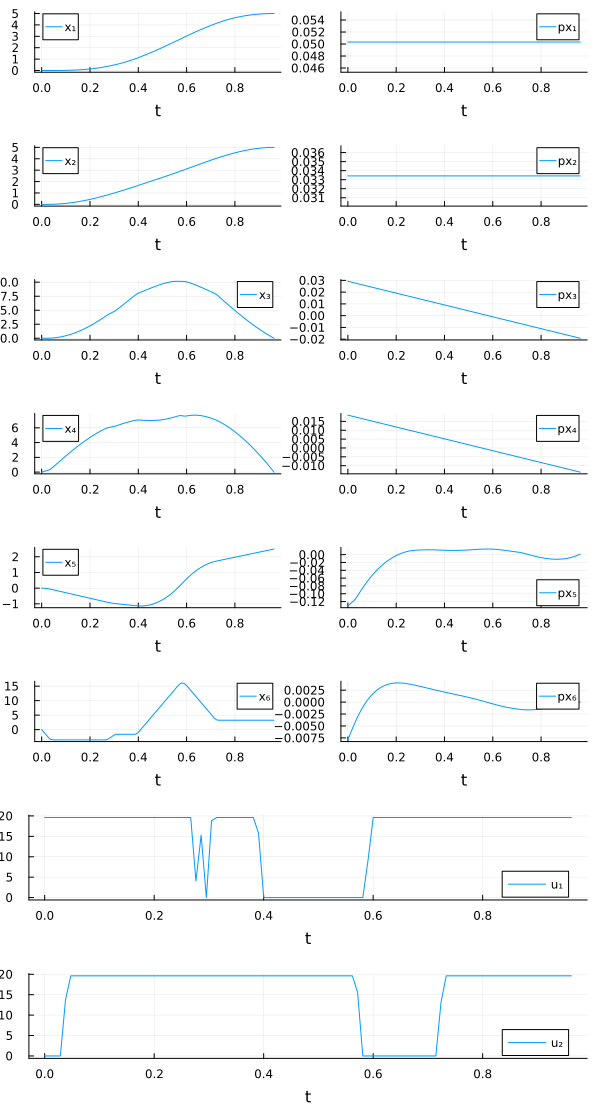

In [60]:
plot(sol)

## 3. Comparison <a id='comp'></a>

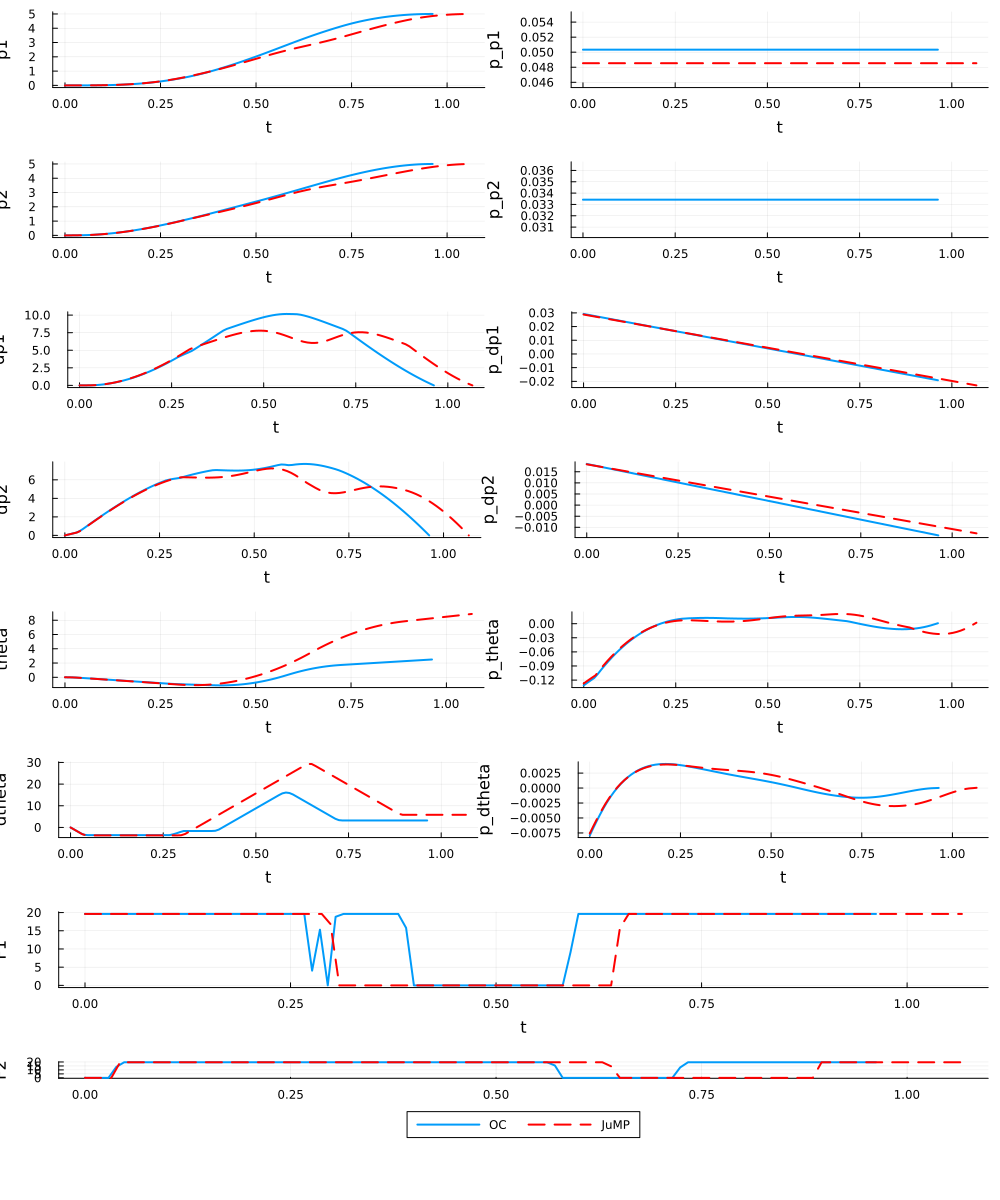

In [61]:
using Plots
plt_p1 = plot(plot(sol)[1],line = 2)
plt_p1 = plot!(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "p1", legend = false,line = 2, color = "red",linestyle=:dash)

plt_p2 = plot(plot(sol)[2],line = 2)
plt_p2 = plot!(t, [ x[i][2] for i in 1:nh+1], xlabel = "t", ylabel = "p2", legend = false,line = 2, color = "red",linestyle=:dash)

plt_dp1 = plot(plot(sol)[3],line = 2)
plt_dp1 = plot!(t, [ x[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "dp1", legend = false,line = 2, color = "red",linestyle=:dash)

plt_dp2 = plot(plot(sol)[4],line = 2)
plt_dp2 = plot!(t, [ x[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "dp2", legend = false,line = 2, color = "red",linestyle=:dash)

plt_theta = plot(plot(sol)[5],line = 2)
plt_theta = plot!(t, [ x[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "theta", legend = false,line = 2, color = "red",linestyle=:dash)

plt_dtheta = plot(plot(sol)[6],line = 2)
plt_dtheta = plot!(t, [ x[i][6] for i in 1:nh+1 ], xlabel = "t", ylabel = "dtheta", legend = false,line = 2, color = "red",linestyle=:dash)

#

plt_pp1 = plot(plot(sol)[7],line = 2)
plt_pp1 = plot!(t, [ p[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_p1", legend = false,line = 2, color = "red",linestyle=:dash)

plt_p_p2 = plot(plot(sol)[8],line = 2)
plt_p_p2 = plot!(t, [ p[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_p2", legend = false,line = 2, color = "red",linestyle=:dash)

plt_p_dp1 = plot(plot(sol)[9],line = 2)
plt_p_dp1 = plot!(t, [ p[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_dp1", legend = false,line = 2, color = "red",linestyle=:dash)

plt_p_dp2 = plot(plot(sol)[10],line = 2)
plt_p_dp2 = plot!(t, [ p[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_dp2", legend = false,line = 2, color = "red",linestyle=:dash)

plt_p_theta = plot(plot(sol)[11],line = 2)
plt_p_theta = plot!(t, [ p[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_theta", legend = false,line = 2, color = "red",linestyle=:dash)

plt_p_dtheta = plot(plot(sol)[12],line = 2)
plt_p_dtheta = plot!(t, [ p[i][6] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_dtheta", legend = false,line = 2, color = "red",linestyle=:dash)

# 
plt_F1 = plot(plot(sol)[13],line = 2)
plt_F1 = plot!(t, [ u[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "F1", legend = false,line = 2, color = "red",linestyle=:dash)

plt_F2 = plot(plot(sol)[14], label ="OC",line = 2)
plt_F2 = plot!(t, [ u[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "F2", legend = false, label = "JuMP",line = 2, color = "red",linestyle=:dash)
plt_F2 = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [a b; c d; e f; g h ;j h; o m;p; n]

x_plot =  plot( plt_p1, plt_pp1, plt_p2, plt_p_p2, plt_dp1, plt_p_dp1, plt_dp2, plt_p_dp2, plt_theta, plt_p_theta, plt_dtheta, plt_p_dtheta, plt_F1, plt_F2, layout = layout)
x_plot = plot!(x_plot, size = (1000, 1200))
display(x_plot)

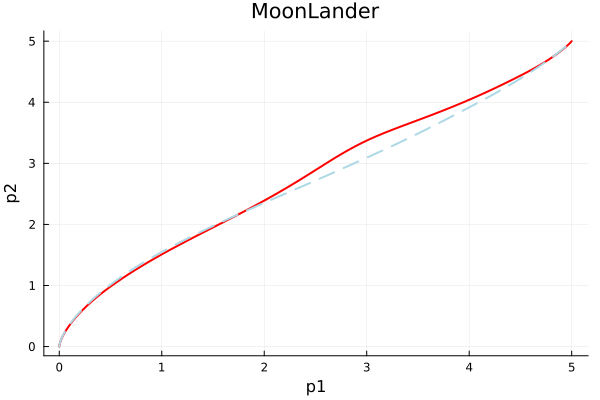

In [62]:
using JuMP
Δt = ones(nh)*step
ts = cumsum([0; value.(Δt)])[1:end-1]
x = [sol.state(t) for t in ts]
pf = plot(
    p1,
    p2,
    linewidth = 2,
    legend = nothing,
    title = "MoonLander",
    xlabel = "p1",
    ylabel = "p2",
    color = "red",
)
pf = plot!(
    [x[i][1] for i in 1:nh],
    [x[i][2] for i in 1:nh],
    linewidth = 2,
    legend = nothing,
    title = "MoonLander",
    xlabel = "p1",
    ylabel = "p2",
    color = "lightblue",
    linestyle=:dash
)

## 4. Remarks <a id='rem'></a>

* `OptimalControl` struggles to find a soltuion with a grid size greater than 300 (Unsolvable for 400).
* `JuMP` is not able to solve the problem with a grid size less than 400 (Unsolvable for 300).
* The first correction is to use the time step as a variable instead of tf for `JuMP`.